### Importando Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importando Base de Dados

In [5]:
#load data from txt file with no head witch the data is splot by :::
trainData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/train_data.txt', sep=':::', engine='python',header=None)
testData = pd.read_table('/content/gdrive/MyDrive/Genre_Classification_Dataset/test_data_solution.txt', sep=':::', engine='python',header=None)
#combing dataset's
data = trainData.append(testData)
#remove index
data = data.drop([0], axis=1)
#set dataframe head 
data.columns = ['name', 'genre','description']

### ETL

In [6]:
#removing whitespaces from the start and end of the colum "genre"
data['genre'] = data['genre'].str.strip()

In [7]:
print("before filtering genres: ",len(data))
filter_list = ['drama', 'comedy', 'horror', 'thriller', 'action', 'mystery', 'sci-fi', 'fantasy', 'western', 'romance', 'music']
data = data[data['genre'].isin(filter_list)]
print("after filtering genres: ",len(data))

before filtering genres:  108414
after filtering genres:  59781


Vamo ver se a gente vai usar isso, talvez tentar primeiro sem:

In [8]:
#creating a "super-genre" out of "horror", "thriller" and "mystery" 
data['genre'] = data['genre'].replace(['horror', 'thriller', 'mystery'], 'h-t-m')

#creating a "super-genre" out of "sci-fi" and "fantasy"
data['genre'] = data['genre'].replace(['sci-fi', 'fantasy'], 's-f')

#reindex data
data = data.reset_index(drop=True)

In [9]:
#removendo possiveis valores nulos de descrição
data = data[data['description'].notna()]

### EDA

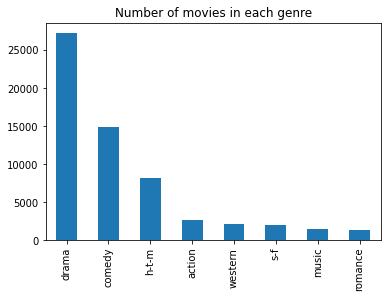

In [10]:
#ploting the number of movies in each genre
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre')

### Construção da Matriz TF-IDF

In [11]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 


In [12]:
import nltk
from nltk import word_tokenize
import string
import unidecode
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')


listStringTerms = []


def criandoLinha(descrição):
    #capturando tokens da descrição
    tokens = word_tokenize(descrição)
    #normalizando para minúsculo
    tokens = [w.lower() for w in tokens]

    #removendo simbolos de pontuação
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    #tratando caracteres especiais
    tokens = [unidecode.unidecode(w) for w in tokens]

    #selecionando apenas palavras
    words = [word for word in tokens if word.isalpha()]

    #removendo palavras com 3 ou menos caracteres
    words = [word for word in words if len(word) > 3]



    #removendo palavras vazias
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

     # Create n-grams


    #redução de palavras
    porter = PorterStemmer()
    stemmedWords = [porter.stem(word) for word in words] 

    n = 2
    ngrams = []
    for i in range(len(words)-n+1):
        ngram = " ".join(words[i:i+n])
        ngrams.append(ngram)

    #transformando lista de stemmedWords em uma string
    stringTerms = ' '.join(stemmedWords)



    return stringTerms

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
#criando a lista de strings de termos
listStringTerms = data['description'].apply(criandoLinha)

In [14]:
##construindo matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(listStringTerms)
X

<59781x20988 sparse matrix of type '<class 'numpy.float64'>'
	with 2492125 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=3)
X_svd = svd.fit_transform(X)

In [16]:
svd.explained_variance_ratio_.sum()

0.09721954036487686

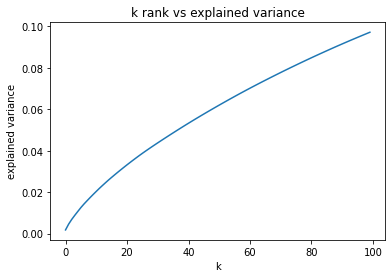

In [17]:
#plot k rank vs explained variance
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('k')
plt.ylabel('explained variance')
plt.title('k rank vs explained variance')
plt.show()


### Agrupamento

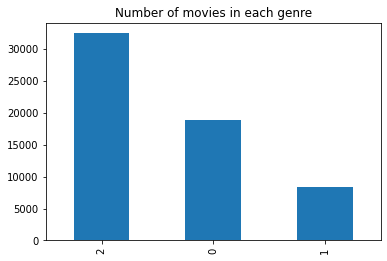

In [18]:
#k means classifier for X_svd
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=45).fit(X_svd)
y_kmeans = kmeans.predict(X_svd)

#ploting the number of movies in each genre
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [19]:
#create a dataframe with y_kmeans
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])
values_counts = pd.Series(y_kmeans).value_counts()
values_counts

2    32502
0    18949
1     8330
dtype: int64

In [20]:
totalMovies = data['genre'].value_counts()

grupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
grupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
grupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]

In [21]:
def genreByGroup(grupo, listTotalMovie, data):
  listCont = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for row in grupo.index:
      genreGroup = data.loc[row]['genre']
      for i in range(0,len(genreList)):
        if genreList[i] == genreGroup:
          listCont[i] += 1

  # Tentando normalizar, ta certo isso?
  for i in range(0,8):
    listCont[i] = listCont[i]/listTotalMovie[genreList[i]]

  plt.bar(genreList,listCont,width = 0.8)
  plt.show()

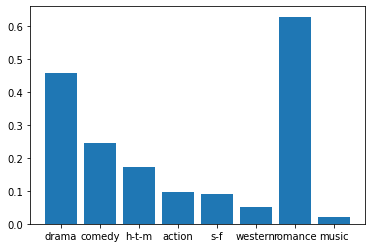

In [22]:
genreByGroup(grupoZero,totalMovies,data)

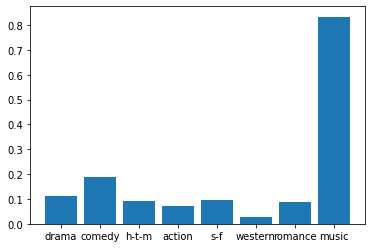

In [23]:
genreByGroup(grupoUm,totalMovies,data)

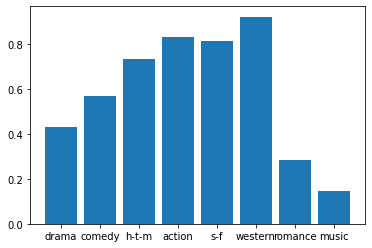

In [24]:
genreByGroup(grupoDois,totalMovies,data)

In [30]:
newDf = data.loc[grupoDois.index.tolist()]
# newTotal = newDf['genre'].value_counts()

NEW_X_svd = X_svd[newDf.index]

newDf = newDf.reset_index(drop=True)
newDf.head(11)

,name,genre,description
0,Cupid (1997),h-t-m,A brother and sister with a past incestuous r...
1,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
2,Spirits (2014/I),h-t-m,Four high school students embark on a terrify...
3,Interrabang (1969),h-t-m,"A photographer is sailing with his wife, her ..."
4,Babylon Vista (2001),comedy,Frankie Reno was a child star on a TV show. B...
5,O Signo das Tetas (2016),drama,The Road of Milk narrates in existential dram...
6,Söderpojkar (1941),comedy,A gang of unemployed itinerant musicians play...
7,The Sandman (????/I),s-f,A wizard attempting to capture Death to barga...
8,The Day Mars Invaded Earth (1963),s-f,The Martians are actually protecting themselv...
9,The Blue Boy (1994),h-t-m,"Marie is an insecure housewife whose husband,..."


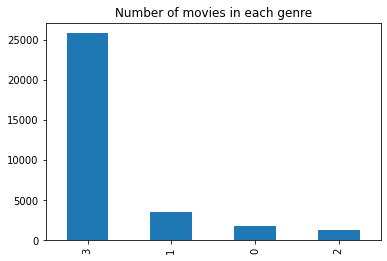

In [48]:
#k means classifier for new_Xsvd
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=45).fit(NEW_X_svd)
y_kmeans = kmeans.predict(NEW_X_svd)

#ploting the number of movies in each genre
pd.Series(y_kmeans).value_counts().plot(kind='bar', title='Number of movies in each genre')

In [49]:
#create a dataframe with y_kmeans
y_kmeans_df = pd.DataFrame(y_kmeans, columns=['genre'])
values_counts = pd.Series(y_kmeans).value_counts()
values_counts

3    25799
1     3558
0     1820
2     1325
dtype: int64

In [50]:
NEWtotalMovies = newDf['genre'].value_counts()
NEWgrupoZero = y_kmeans_df[y_kmeans_df['genre'] == 0]
NEWgrupoUm = y_kmeans_df[y_kmeans_df['genre'] == 1]
NEWgrupoDois = y_kmeans_df[y_kmeans_df['genre'] == 2]
NEWgrupoTres = y_kmeans_df[y_kmeans_df['genre'] == 3]
NEWtotalMovies

drama      11757
comedy      8448
h-t-m       6039
action      2181
western     1903
s-f         1579
romance      380
music        215
Name: genre, dtype: int64

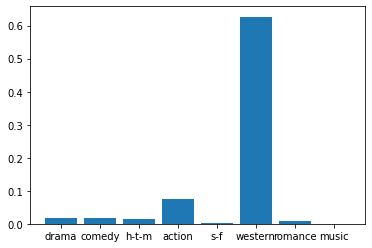

In [51]:
genreByGroup(NEWgrupoZero,NEWtotalMovies,newDf)

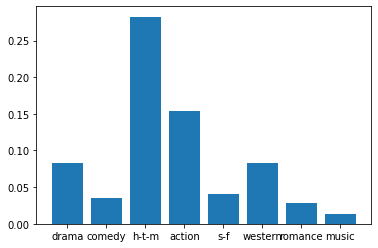

In [52]:
genreByGroup(NEWgrupoUm,NEWtotalMovies,newDf)

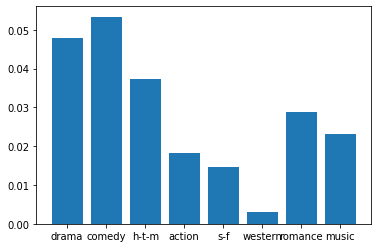

In [53]:
genreByGroup(NEWgrupoDois,NEWtotalMovies,newDf)

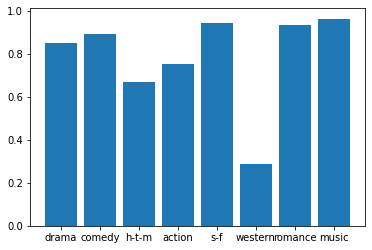

In [54]:
genreByGroup(NEWgrupoTres,NEWtotalMovies,newDf)

### Agrupamento Hierárquico


########################################## TESTANDO BASE DE DADOS MENOR

In [121]:
def reduzBaseDatos():
  totalMovies = data['genre'].value_counts()
  total = 0
  listPesos = [0,0,0,0,0,0,0,0]
  genreList = ['drama', 'comedy','h-t-m','action','s-f','western','romance','music']

  for i in totalMovies:
    total += i

  for i in range(0,8):
    listPesos[i] = data['genre'].value_counts()[genreList[i]]/total


  newQtdMoviesByGeng = []
  for i in range(0,8):
    newQtdMoviesByGeng.append(round(5000*listPesos[i]))

  listNewDf = []
  for i in range(0,8):
    df = data[data['genre'] == genreList[i]]
    df = df.sample(newQtdMoviesByGeng[i])

    listNewDf.append(df)

  for i in range(1,len(listNewDf)):
    listNewDf[0] = listNewDf[0].append(listNewDf[i])

  newData = listNewDf[0]
  newData = newData.reset_index(drop=True)
  
  return newData


In [122]:
newData = reduzBaseDatos()
#criando a lista de strings de termos
newListStringTerms = newData['description'].apply(criandoLinha)
##construindo matriz TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
newNectorizer = TfidfVectorizer(min_df = 5)
newX = newNectorizer.fit_transform(newListStringTerms)
newX

<5000x5406 sparse matrix of type '<class 'numpy.float64'>'
	with 190456 stored elements in Compressed Sparse Row format>

In [123]:
from sklearn.decomposition import TruncatedSVD
newSvd = TruncatedSVD(n_components=100, random_state=3)
NEW_X_svd = newSvd.fit_transform(newX)

In [124]:
newSvd.explained_variance_ratio_.sum()

0.1485517930342239

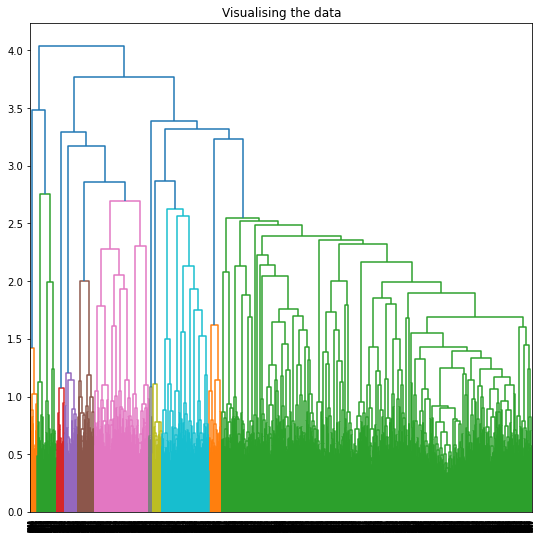

In [125]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize =(9, 9))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(NEW_X_svd, method ='ward')))

##########################################

In [ ]:
from sklearn.cluster import AgglomerativeClustering

m = AgglomerativeClustering(n_clusters = 6, linkage = 'average')
m.fit(X_svd)

In [ ]:
#m.labels_
np.unique(m.labels_)


array([0, 1, 2, 3, 4, 5])

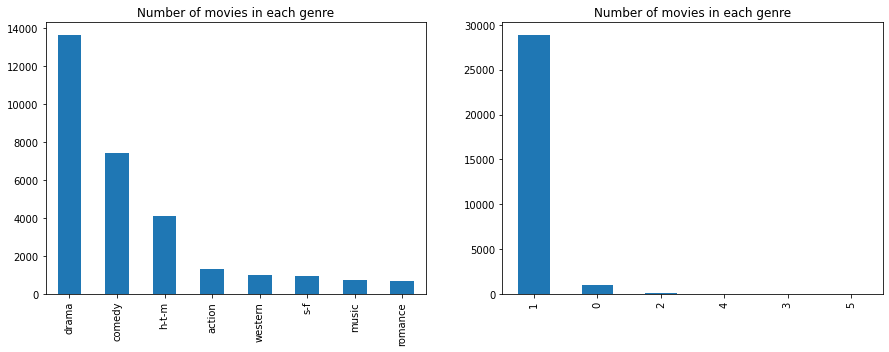

In [ ]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(m.labels_).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [ ]:
y_ah_df = pd.DataFrame(m.labels_, columns=['genre'])
values_counts = pd.Series(m.labels_).value_counts()
values_counts

1    28820
0      991
2       76
4        4
3        2
5        1
dtype: int64

### Agrupamento Espectral

In [ ]:
from sklearn.cluster import SpectralClustering

m = SpectralClustering(n_clusters = 6, affinity = 'nearest_neighbors', n_neighbors = 10)
#m = SpectralClustering(n_clusters = 3)
m.fit(X_svd)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors')

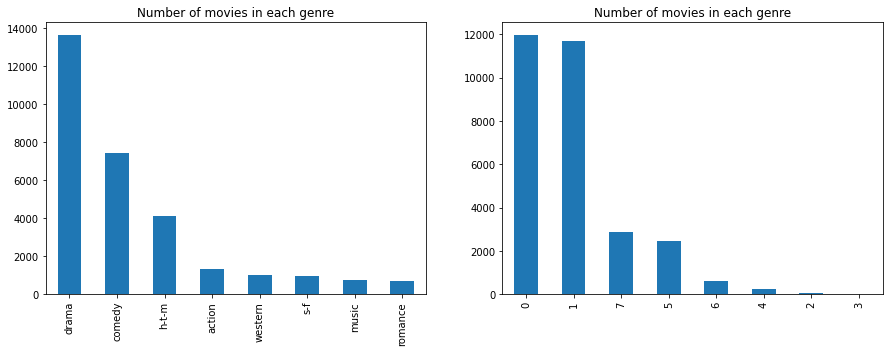

In [ ]:
#plot both count plots of genre on top of each other
fig, ax = plt.subplots(1,2, figsize=(15,5))
data['genre'].value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[0])
pd.Series(m.labels_).value_counts().plot(kind='bar', title='Number of movies in each genre', ax=ax[1])
plt.show()

In [ ]:
y_sc_df = pd.DataFrame(m.labels_, columns=['genre'])
values_counts = pd.Series(m.labels_).value_counts()
values_counts

0    11952
1    11700
7     2864
5     2469
6      599
4      253
2       39
3       18
dtype: int64